<a href="https://colab.research.google.com/github/syllerim/deep-learning-skin-diagnosis/blob/main/3_HAM10000_Fusions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 **Deep Learning - Diagnosis of Pigmented Skin Lesion using The HAM10000** 🧠

Use Google Colab

In [265]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 🧑‍🍳 **Set up paths to dataset files stored in Google Drive** 🗄️

In [266]:
# define base directory where the dataset files are stored in Google Drive
DATA_DIR = '/content/drive/MyDrive/KeepCoding/Bootcamp_AI/DeepLearning'

# models
PATH_TABULAR_MODEL = f'{DATA_DIR}/HAM_tabular_model.keras'
PATH_IMAGE_MODEL = f'{DATA_DIR}/HAM_image_model.keras'
PATH_IMAGE_MODEL_LATE_FUSION = f'{DATA_DIR}/HAM_model_late_fusion.keras'
PATH_IMAGE_MODEL_EARLY_FUSION = f'{DATA_DIR}/HAM_model_early_fusion.keras'

# indexes
PATH_METADATA_TRAIN_IDX = f'{DATA_DIR}/HAM_metadata_train_idx.npy'
PATH_METADATA_VAL_IDX = f'{DATA_DIR}/HAM_metadata_val_idx.npy'

# metadata
PATH_METADATA_DEV2 = f'{DATA_DIR}/HAM10000_metadata_dev2.csv'
PATH_METADATA_TEST2 = f'{DATA_DIR}/HAM10000_metadata_test2.csv'

# images
PATH_IMAGES_DEV = f'{DATA_DIR}/hnmist_28_28_RGB_dev.csv'
PATH_IMAGES_TEST = f'{DATA_DIR}/hnmist_28_28_RGB_test.csv'

# embeddings
PATH_EMBEDDINGS_TRAIN = f'{DATA_DIR}/hnmist_embeddings_train.csv'
PATH_EMBEDDINGS_VAL = f'{DATA_DIR}/hnmist_embeddings_val.csv'
PATH_EMBEDDINGS_TEST = f'{DATA_DIR}/hnmist_embeddings_test.csv'

# images final slices
PATH_IMAGES_FINAL_SLICES_TRAIN = f'{DATA_DIR}/hnmist_final_slices_train.csv'
PATH_IMAGES_FINAL_SLICES_VAL = f'{DATA_DIR}/hnmist_final_slices_val.csv'
PATH_IMAGES_FINAL_SLICES_TEST = f'{DATA_DIR}/hnmist_final_slices_test.csv'

# images_final_slices
PATH_IMAGES_FINAL_SLICES_TRAIN = f'{DATA_DIR}/hnmist_final_slices_train.csv'
PATH_IMAGES_FINAL_SLICES_VAL = f'{DATA_DIR}/hnmist_final_slices_val.csv'
PATH_IMAGES_FINAL_SLICES_TEST = f'{DATA_DIR}/hnmist_final_slices_test.csv'


In [267]:
# import the main libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow as tf
import numpy as np

from keras.saving import save_model

from sklearn.metrics import classification_report
from sklearn.utils.multiclass import type_of_target

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Input
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD

In [268]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## ⛙ **Assignment 3 - 4**

Since I already have two trained models, one for the tabular data and one for the images, I'll start exploring fusion techniques to see if combining them improves the overall performance.

### **Methods**

In [269]:
def load_target_labels(path_to_csv, target_prefix, index_slice=None):
    df = pd.read_csv(path_to_csv)

    if index_slice is not None:
      df = df.loc[index_slice]

    target_cols = [col for col in df.columns if col.startswith(target_prefix)]
    y = df[target_cols]

    return y

In [270]:
def build_model(
    name,
    input_dim,
    output_dim,
    hidden_layers,
    activation_function=None,
    last_activation='softmax',
    dropout_rates=None):
    """
    Build a sequential model.

    Parameters:
    - name: name for the model
    - input_dim: int, number of features.
    - output_dim: int, number of output classes.
    - hidden_layers: list of ints, each representing number of units per hidden layer.
    - activation_function: activation for hidden layers.
    - last_activation: activation for output layer (default = softmax).
    - dropout_rates: dropout values

    Returns:
    - model: compiled Sequential model (not compiled).
    """
    model = Sequential(name=name)
    model.add(Input(shape=(input_dim,), name=f"{name}_input"))

    for i, units in enumerate(hidden_layers):
      dense_name = f"{name}_dense_{i}"
      if activation_function:
        model.add(
          Dense(units, activation=activation_function, name=dense_name)
        )
      else:
        model.add(Dense(units, name=dense_name))
        if dropout_rates and i < len(dropout_rates):
          dropout_name = f"{name}_dropout_{i}"
          model.add(Dropout(dropout_rates[i], name=dropout_name))

    model.add(
      Dense(output_dim, activation=last_activation, name=f"{name}_output")
    )
    return model

In [271]:
def apply_dense_stack(
    name,
    input_layer,
    hidden_layers,
    activation_function=None,
    dropout_rates=None,
    output_dim=7,
    last_activation='softmax'):

  x = input_layer
  for i, units in enumerate(hidden_layers):
    dense_name = f"{name}_dense_{i}"
    x = Dense(units, activation=activation_function, name=dense_name)(x)
    if dropout_rates and i < len(dropout_rates):
      x = Dropout(dropout_rates[i])(x)
  x = Dense(output_dim, activation=last_activation)(x)
  return x

In [272]:
def build_late_fusion_model(
    tabular_model,
    vision_model,
    hidden_layers,
    dropout_rates=None):

  # freeze their weights before fusion
  tabular_model.trainable = False
  vision_model.trainable = False

  # get the shapes of both models
  tabular_input = Input(
      shape=tabular_model.input_shape[1:], name="tabular_input"
  )
  vision_input = Input(
      shape=vision_model.input_shape[1:], name="vision_input"
  )

  # pass inputs through each model already trained
  tabular_embedding = tabular_model(tabular_input)
  vision_embedding = vision_model(vision_input)

  # fusion of concatenated probabilities
  fused = Concatenate()([tabular_embedding, vision_embedding])

  fused_output = apply_dense_stack(
      'fused_tabular_vision_model',
      fused,
      hidden_layers=hidden_layers,
      activation_function='relu',
      dropout_rates=dropout_rates,
      output_dim=7,
      last_activation="softmax"
  )

  model = Model(inputs=[tabular_input, vision_input], outputs=fused_output)
  return model

In [273]:
def build_early_fusion_model(
    name,
    tabular_model,
    vision_model,
    is_early=False,
    hidden_layers=[128, 64, 32],
    activation_function='relu',
    dropout_rates=None,
    output_dim=7,
    last_activation='softmax'
    ):

  tabular_model.trainable = False
  vision_model.trainable = False

  # get the shapes of both models
  tabular_input= Input(
      shape=tabular_model.input_shape[1:], name="tabular_input"
  )
  vision_input = Input(
      shape=vision_model.input_shape[1:], name="vision_input"
  )

  if is_early:
    tabular_intermediate_model = Model(
      inputs=tabular_input,
      outputs=tabular_model.layers[-2].output,
      name="tabular_intermediate"
    )
    tabular_intermediate_model.summary()

    vision_intermediate_model = Model(
      inputs=vision_input,
      outputs=vision_model.layers[-2].output,
      name="vision_intermediate"
    )
    vision_intermediate_model.summary()

    tabular_embedding = tabular_intermediate_model(tabular_input)
    vision_embedding = vision_intermediate_model(vision_input)

    # match the dimension of the tabular embedding
    tabular_embedding = Dense(32, activation='relu')(tabular_embedding)

  else:
    tabular_embedding = tabular_model(tabular_input)
    vision_embedding = vision_model(vision_input)

  # merge the representation of both modalities
  fused = Concatenate(name=name)([tabular_embedding, vision_embedding])

  # add classifier
  fused_output = apply_dense_stack(
    name,
    fused,
    hidden_layers=hidden_layers,
    activation_function=activation_function,
    dropout_rates=dropout_rates,
    output_dim=output_dim,
    last_activation=last_activation
  )

  model = Model(inputs=[tabular_input, vision_input], outputs=fused_output)

  return model

In [274]:
def train_deep_net(
    model,
    batch_size,
    learning_rate,
    num_epochs,
    x_train,
    x_val,
    x_test,
    y_train,
    y_val,
    y_test,
    callbacks=None):

  # compile and train the SGD model
  print("[INFO]: Training the Neural Network...")

  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
  )

  if callbacks is None:
    callbacks = []

  # train the model
  H = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=callbacks
  )

  # evaluate the prediction model
  print("[INFO]: Evaluando neural network...")

  predictions = model.predict(x_test, batch_size=batch_size)
  true_labels = y_test.to_numpy().argmax(axis=1) if hasattr(y_test, 'to_numpy') else y_test.argmax(axis=1)

  print(
    classification_report(
        true_labels,
        predictions.argmax(axis=1),
        zero_division=0
    )
  )

  return model, H

### 📊 **Prepare Training / Validation / Test Datasets**

#### **X Tabular**

In [275]:
# get metadata dev & test after imputations and transformations
df_metadata_dev = pd.read_csv(PATH_METADATA_DEV2)
df_metadata_test = pd.read_csv(PATH_METADATA_TEST2)

# get target features in dev and test
dx_columns_dev = [col for col in df_metadata_dev.columns if col.startswith('dx_')]
dx_columns_test = [col for col in df_metadata_test.columns if col.startswith('dx_')]

# remove target features from dev & test
X_metadata_dev = df_metadata_dev.drop(columns=dx_columns_dev)
X_tabular_test= df_metadata_test.drop(columns=dx_columns_test)

# split dev into train & val
train_metadata_idx = np.load(PATH_METADATA_TRAIN_IDX, allow_pickle=True)
X_tabular_train = X_metadata_dev.loc[train_metadata_idx]

val_metadata_idx = np.load(PATH_METADATA_VAL_IDX, allow_pickle=True)
X_tabular_val = X_metadata_dev.loc[val_metadata_idx]

print(f'X_tabular_train Shape: {X_tabular_train.shape}')
print(f'X_tabular_val Shape: {X_tabular_val.shape}')
print(f'X_tabular_test Shape: {X_tabular_test.shape}')

X_tabular_train Shape: (6379, 21)
X_tabular_val Shape: (1595, 21)
X_tabular_test Shape: (1994, 21)


#### **y Tabular**


In [276]:
y_tabular_train = df_metadata_dev.loc[train_metadata_idx]
y_tabular_train = y_tabular_train[dx_columns_dev]

y_tabular_val = df_metadata_dev.loc[val_metadata_idx]
y_tabular_val = y_tabular_val[dx_columns_dev]
y_tabular_test = df_metadata_test[dx_columns_test]

print(f'y_tabular_train Shape: {y_tabular_train.shape}')
print(f'y_tabular_val Shape: {y_tabular_val.shape}')
print(f'y_tabular_test Shape: {y_tabular_test.shape}')

y_tabular_train Shape: (6379, 7)
y_tabular_val Shape: (1595, 7)
y_tabular_test Shape: (1994, 7)


#### **X Image**

In [277]:
X_image_train = pd.read_csv(PATH_EMBEDDINGS_TRAIN)
X_image_val = pd.read_csv(PATH_EMBEDDINGS_VAL)
X_image_test = pd.read_csv(PATH_EMBEDDINGS_TEST)

print(f'X_vision_train Shape: {X_image_train.shape}')
print(f'X_vision_val Shape: {X_image_val.shape}')
print(f'X_vision_test Shape: {X_image_test.shape}')

X_vision_train Shape: (6379, 1280)
X_vision_val Shape: (1595, 1280)
X_vision_test Shape: (1994, 1280)


### 🧬 **The Models**

In [278]:
# load tabular model
tabular_model = load_model(PATH_TABULAR_MODEL, compile=False)
print(f'tabular_model shape: {tabular_model.input_shape[1:]}')
tabular_model.summary()

tabular_model shape: (21,)


Model: "tabular_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ tabular_model_dense_0 (Dense)        │ (None, 200)                 │           4,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ tabular_model_dense_1 (Dense)        │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ tabular_model_dense_2 (Dense)        │ (None, 60)                  │           6,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ tabular_model_dense_3 (Dense)        │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ tabular_model_output (Dense)         │ (None, 7)                   │             217 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,607 (127.37 KB)

 Trainable params: 32,607 (127.37 KB)

 Non-trainable params: 0 (0.00 B)

In [279]:
# load image model
vision_model = load_model(PATH_IMAGE_MODEL, compile=False)
print(f'vision_model shape: {vision_model.input_shape[1:]}')
vision_model.summary()

vision_model shape: (1280,)


Model: "image_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_model_1_dense_0 (Dense)        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ image_model_1_dense_1 (Dense)        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ image_model_1_dense_2 (Dense)        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ image_model_1_output (Dense)         │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 174,535 (681.78 KB)

 Trainable params: 174,535 (681.78 KB)

 Non-trainable params: 0 (0.00 B)

### 🏃‍♂️💨 **Late-Fusion**

In [280]:
# late fuse the tabular and vision models
late_fuse_model = build_late_fusion_model(
    tabular_model,
    vision_model,
    hidden_layers=[64, 7],
    dropout_rates=[0.3]
)
late_fuse_model.summary()

Model: "functional_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tabular_input             │ (None, 21)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vision_input (InputLayer) │ (None, 1280)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tabular_model             │ (None, 7)              │         32,607 │ tabular_input[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_model_1             │ (None, 7)              │        174,535 │ vision_input[0][0]     │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_17            │ (None, 14)             │              0 │ tabular_model[0][0],   │
│ (Concatenate)             │                        │                │ image_model_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fused_tabular_vision_mod… │ (None, 64)             │            960 │ concatenate_17[0][0]   │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 64)             │              0 │ fused_tabular_vision_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fused_tabular_vision_mod… │ (None, 7)              │            455 │ dropout_21[0][0]       │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 7)              │             56 │ fused_tabular_vision_… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 208,613 (814.89 KB)

 Trainable params: 1,471 (5.75 KB)

 Non-trainable params: 207,142 (809.15 KB)

In [281]:
# hyperparameters
batch_size = 32
learning_rate = 1e-3
num_epochs = 30
hidden_layers = [128, 64, 32]
dropout_rates = [0.5, 0.3]

early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    restore_best_weights=True
)

⚠ Here it's important to notet that **X** and **y** must be the **fused** corresponding **datasets**

In [282]:
# call the training function
late_fuse_model_train, H_late = train_deep_net(
    late_fuse_model,
    batch_size=batch_size,
    learning_rate=learning_rate,
    num_epochs=num_epochs,
    x_train=[X_tabular_train, X_image_train],
    x_val=[X_tabular_val, X_image_val],
    x_test=[X_tabular_test, X_image_test],
    y_train=y_tabular_train,
    y_val=y_tabular_val,
    y_test=y_tabular_test,
    callbacks=[early_stop]
)

[INFO]: Training the Neural Network...
Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2221 - loss: 1.8936 - val_accuracy: 0.6746 - val_loss: 1.7982
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6583 - loss: 1.7743 - val_accuracy: 0.6683 - val_loss: 1.6769
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6699 - loss: 1.6482 - val_accuracy: 0.6683 - val_loss: 1.5505
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6752 - loss: 1.5157 - val_accuracy: 0.6683 - val_loss: 1.4208
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6757 - loss: 1.3839 - val_accuracy: 0.6683 - val_loss: 1.2971
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6708 - loss: 1.2710 - val_accuracy: 0.6683 - val_loss: 1.1942
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6727 - loss: 1.1658 - val_accuracy: 0.6683 - val_loss: 1.1200
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0

In [283]:
late_fuse_model_train.summary()

Model: "functional_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tabular_input             │ (None, 21)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vision_input (InputLayer) │ (None, 1280)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tabular_model             │ (None, 7)              │         32,607 │ tabular_input[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_model_1             │ (None, 7)              │        174,535 │ vision_input[0][0]     │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_17            │ (None, 14)             │              0 │ tabular_model[0][0],   │
│ (Concatenate)             │                        │                │ image_model_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fused_tabular_vision_mod… │ (None, 64)             │            960 │ concatenate_17[0][0]   │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 64)             │              0 │ fused_tabular_vision_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fused_tabular_vision_mod… │ (None, 7)              │            455 │ dropout_21[0][0]       │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 7)              │             56 │ fused_tabular_vision_… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 208,615 (814.91 KB)

 Trainable params: 1,471 (5.75 KB)

 Non-trainable params: 207,142 (809.15 KB)

 Optimizer params: 2 (12.00 B)

In [284]:
# evaluate the fused model on the test set
test_loss_fuse, test_acc_fuse = late_fuse_model_train.evaluate([X_tabular_test, X_image_test], y_tabular_test)
print(f"Test accuracy: {test_acc_fuse:.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6746 - loss: 0.8717
Test accuracy: 0.67


In [ ]:
# save the model
# save_model(late_fuse_model_train, PATH_IMAGE_MODEL_LATE_FUSION)

In [ ]:
# save history object
# with open("history-late.pkl", "wb") as f:
#   pickle.dump(H_late.history, f)

In [285]:
model_saved = load_model(PATH_IMAGE_MODEL_LATE_FUSION, compile=False)

In [286]:
# load history object
with open("history-late.pkl", "rb") as f:
  history_l = pickle.load(f)

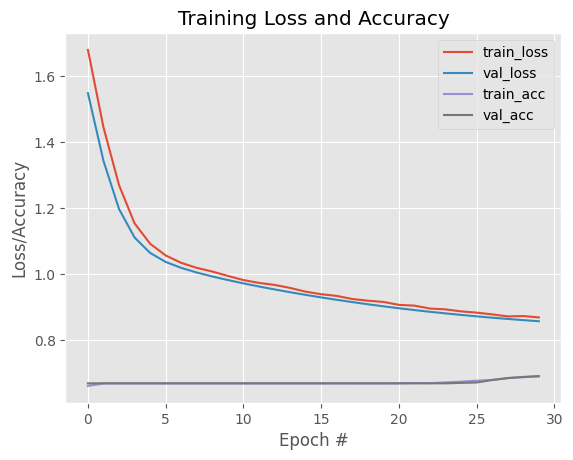

In [287]:
# show accuracy y losses graphs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history_l["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history_l["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_epochs), history_l["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history_l["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

The accuracy after fusing both models does not show a significant improvement. It remains around 0.70, similar to the individual models.

### 🌅☕ **Early Fusion**

The first step is to remove the final classification layer from both partial models, since we don't want to use their predictions directly. Instead, we aim to extract their internal feature representations. Then, homogenize the output dimensions so both embeddings have the same size before concatenation.

In [375]:
tabular_model.summary()

Model: "tabular_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ tabular_model_dense_0 (Dense)        │ (None, 200)                 │           4,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ tabular_model_dense_1 (Dense)        │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ tabular_model_dense_2 (Dense)        │ (None, 60)                  │           6,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ tabular_model_dense_3 (Dense)        │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ tabular_model_output (Dense)         │ (None, 7)                   │             217 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,607 (127.37 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 32,607 (127.37 KB)

In [376]:
tabular_model.trainable = False
vision_model.trainable = False

In [377]:
shape_tabular=tabular_model.input_shape[1:]
shape_tabular

(21,)

In [378]:
shape_vision = vision_model.input_shape[1:]
shape_vision

(1280,)

In [379]:
# get the shapes of both models
tabular_input= Input(shape=shape_tabular, name="tabular_input")
vision_input = Input(shape=shape_vision, name="vision_input")

In [380]:
tabular_model.get_layer('tabular_model_dense_3').output

<KerasTensor shape=(None, 30), dtype=float32, sparse=False, name=keras_tensor_415>

In [381]:
vision_model.get_layer('image_model_1_dense_2').output

<KerasTensor shape=(None, 32), dtype=float32, sparse=False, name=keras_tensor_426>

In [382]:
tabular_intermediate = Model(
  inputs=tabular_model.input,
  outputs=tabular_model.get_layer('tabular_model_dense_3').output,
  name="tabular_intermediate"
)

In [383]:
vision_intermediate = Model(
  inputs=vision_model.input,
  outputs=vision_model.get_layer('image_model_1_dense_2').output,
  name="vision_intermediate"
)

In [384]:
tabular_features = tabular_intermediate(tabular_input)
vision_features = vision_intermediate(vision_input)

In [385]:
tabular_features

<KerasTensor shape=(None, 30), dtype=float32, sparse=False, name=keras_tensor_485>

In [386]:
vision_features

<KerasTensor shape=(None, 32), dtype=float32, sparse=False, name=keras_tensor_486>

In [387]:
tabular_features = Dense(32, activation='relu')(tabular_features)

In [388]:
merged = Concatenate()([tabular_features, vision_features])

In [389]:
merged

<KerasTensor shape=(None, 64), dtype=float32, sparse=False, name=keras_tensor_488>

In [390]:
x = Dense(64, activation="relu")(merged)
x = Dropout(0.3)(x)
output = Dense(7, activation="softmax", name="final_output_early")(x)

In [391]:
early_fusion_model = Model(inputs=[tabular_input, vision_input], outputs=output)

In [392]:
early_fusion_model.summary()

Model: "functional_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tabular_input             │ (None, 21)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tabular_intermediate      │ (None, 30)             │         32,390 │ tabular_input[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vision_input (InputLayer) │ (None, 1280)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_39 (Dense)          │ (None, 32)             │            992 │ tabular_intermediate[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vision_intermediate       │ (None, 32)             │        174,304 │ vision_input[0][0]     │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_19            │ (None, 64)             │              0 │ dense_39[0][0],        │
│ (Concatenate)             │                        │                │ vision_intermediate[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_40 (Dense)          │ (None, 64)             │          4,160 │ concatenate_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 64)             │              0 │ dense_40[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ final_output_early        │ (None, 7)              │            455 │ dropout_23[0][0]       │
│ (Dense)                   │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 212,301 (829.30 KB)

 Trainable params: 5,607 (21.90 KB)

 Non-trainable params: 206,694 (807.40 KB)

In [393]:
# hyperparameters
batch_size = 32
learning_rate = 1e-3
num_epochs = 30

early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    restore_best_weights=True
)

In [394]:
early_fusion_model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=1e-3),
  metrics=['accuracy']
)

In [347]:
print("Model inputs:")
print(early_fusion_model.inputs)

print("Shapes:")
print("X_tabular_train:", X_tabular_train.shape)
print("X_image_train:", X_image_train.shape)
print("y_tabular_train:", y_tabular_train.shape)

Model inputs:
[<KerasTensor shape=(None, 21), dtype=float32, sparse=False, name=tabular_input>, <KerasTensor shape=(None, 1280), dtype=float32, sparse=False, name=vision_input>]
Shapes:
X_tabular_train: (6379, 21)
X_image_train: (6379, 1280)
y_tabular_train: (6379, 7)


In [371]:
x_train=[X_tabular_train, X_image_train],
x_val=[X_tabular_val, X_image_val],
x_test=[X_tabular_test, X_image_test],
validation_data=(x_val, y_tabular_val)

In [396]:
tabular_input

<KerasTensor shape=(None, 21), dtype=float32, sparse=False, name=tabular_input>

In [402]:
H_early = early_fusion_model.fit(
    x=[X_tabular_train, X_image_train],
    y=y_tabular_train,
    batch_size=batch_size,
    epochs=num_epochs,
    callbacks=[early_stop],
    validation_data=([X_tabular_val, X_image_val], y_tabular_val)
)

Epoch 1/30


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m136568703753360\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(None, 21), dtype=float32)\n  • training=True\n  • mask=None'

In [ ]:
# evaluate the early fusion model on the test set
test_loss_early, test_acc_early = early_fusion_model.evaluate(X_early_test, y_tabular_test)
print(f"Test accuracy: {test_acc_early:.2f}")

In [ ]:
# save the model
# save_model(late_fuse_model_train, PATH_IMAGE_MODEL_EARLY_FUSION)

In [ ]:
# save history object
# with open("history-early.pkl", "wb") as f:
#   pickle.dump(H_early.history, f)

In [ ]:
model_saved = load_model(PATH_IMAGE_MODEL_EARLY_FUSION, compile=False)

In [ ]:
# load history object
with open("history-early.pkl", "rb") as f:
  history_e = pickle.load(f)

Comparison early or late fusion.

In [ ]:
epochs = range(len(history_e["loss"]))

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Early Fusion
axs[0].plot(epochs, history_e["loss"], label="train_loss")
axs[0].plot(epochs, history_e["val_loss"], label="val_loss")
axs[0].plot(epochs, history_e["accuracy"], label="train_acc")
axs[0].plot(epochs, history_e["val_accuracy"], label="val_acc")
axs[0].set_title("Early Fusion")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss/Accuracy")
axs[0].legend()

# Late Fusion
axs[1].plot(epochs, history_l["loss"], label="train_loss")
axs[1].plot(epochs, history_l["val_loss"], label="val_loss")
axs[1].plot(epochs, history_l["accuracy"], label="train_acc")
axs[1].plot(epochs, history_l["val_accuracy"], label="val_acc")
axs[1].set_title("Late Fusion")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss/Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
print(history_e["val_accuracy"][:5])
print(history_l["val_accuracy"][:5])